# 层次

GRIB2 要素场的层次信息与使用的产品模板 (productDefinitionTemplateNumber) 有关。

CEMC 模式 GRIB2 产品大部分要素均使用产品模板 4.0 (瞬时要素) 和 4.8 (统计要素)。
两种模板都支持设置两个层次，每个层次可以设置层次类型和层次值。相关 GRIB KEY 如下

| GRIB KEY | 描述 |
| --- | --- |
| typeOfFirstFixedSurface | 层次类型 |
| scaleFactorOfFirstFixedSurface | 层次值 |
| scaledValueOfFirstFixedSurface | 层次值 |
| typeOfSecondFixedSurface | 层次类型 |
| scaleFactorOfSecondFixedSurface | 层次值 |
| scaledValueOfSecondFixedSurface | 层次值 |

计算层次值的公式如下：

$$
level = 10^{-f} \cdot v
$$

对于第一个层次来说，`f` 是 `scaleFactorOfFirstFixedSurface`，`v` 是 `scaledValueOfFirstFixedSurface`。

ecCodes 额外提供 `typeOfLevel` 和 `level` 两个 GRIB Key 表示层次类型和层次值，支持大部分要素场，但不支持某些使用两个层次的要素场。

下面介绍 reki 支持的几种检索层次的方法。

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from reki.data_finder import find_local_file
from reki.format.grib.eccodes import load_field_from_file

In [2]:
start_time = pd.Timestamp.utcnow().floor(freq="D") - pd.Timedelta(days=2)
start_time_label = start_time.strftime("%Y%m%d%H")
forecast_time_label = "24h"
forecast_time = pd.to_timedelta(forecast_time_label)

gfs_grib2_orig_file_path = find_local_file(
    "cma_gfs_gmf/grib2/orig",
    start_time=start_time,
    forecast_time=forecast_time,
)
gfs_grib2_orig_file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Prod-grib/2025070500/ORIG/gmf.gra.2025070500024.grb2')

In [9]:
gfs_grib2_modelvar_file_path = find_local_file(
    "cma_gfs_gmf/grib2/modelvar",
    start_time=start_time,
    forecast_time=forecast_time,
)
gfs_grib2_modelvar_file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Prod-grib/2025070500/MODELVAR/modelvar2025070500024.grb2')

## ecCodes的typeOfLevel和level

CMA-GFS 的 GRIB2 文件所有要素使用的 typeOfLevel 如下：

In [5]:
from IPython.utils.capture import capture_output

with capture_output() as captured:
    !module load eccodes/2.29.0/intel && grib_ls -p typeOfLevel "{gfs_grib2_orig_file_path}" | tail -n +3 | head -n -3 | sort | uniq -c

print(f"{captured.stdout}")

      4 atmosphere  
      8 depthBelowLandLayer 
      4 entireAtmosphere 
     29 heightAboveGround 
      3 heightAboveGroundLayer 
    748 isobaricInhPa 
     12 isobaricInPa 
      2 meanSea     
      6 nominalTop  
     45 surface     



使用 typeOfLevel 和对应的 level 值可以加载要素场：

In [7]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="u",
    level_type="heightAboveGround",
    level=100,
)
field

<xarray.DataArray 'u' (latitude: 1440, longitude: 2880)> Size: 33MB
array([[-2.66853125, -2.66053125, -2.65353125, ..., -2.68053125,
        -2.67553125, -2.67253125],
       [-1.84853125, -1.84153125, -1.83553125, ..., -1.86153125,
        -1.85653125, -1.85253125],
       [-2.03953125, -2.03253125, -2.02653125, ..., -2.05153125,
        -2.04753125, -2.04353125],
       ...,
       [ 0.68046875,  0.70146875,  0.72046875, ...,  0.62746875,
         0.64446875,  0.66146875],
       [ 1.12646875,  1.14346875,  1.16146875, ...,  1.07446875,
         1.09346875,  1.11046875],
       [-0.21653125, -0.20253125, -0.18553125, ..., -0.25753125,
        -0.24253125, -0.22853125]], shape=(1440, 2880))
Coordinates:
    time               datetime64[ns] 8B 2025-07-05
    step               timedelta64[ns] 8B 1 days
    valid_time         datetime64[ns] 8B 2025-07-06
    heightAboveGround  int64 8B 100
  * latitude           (latitude) float64 12kB 89.94 89.81 ... -89.81 -89.94
  * longitude          (longitude) float64 23kB 0.0 0.125 0.25 ... 359.8 359.9
Attributes: (12/17)
    GRIB_edition:             2
    GRIB_centre:              babj
    GRIB_subCentre:           0
    GRIB_tablesVersion:       4
    GRIB_localTablesVersion:  0
    GRIB_dataType:            fc
    ...                       ...
    GRIB_stepType:            instant
    GRIB_stepUnits:           1
    GRIB_stepRange:           24
    GRIB_endStep:int:         24
    GRIB_count:               49
    long_name:                discipline=0 parmcat=2 parm=2

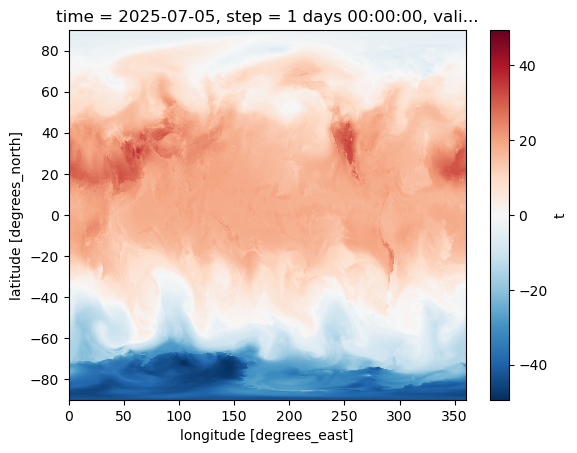

In [8]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="t",
    level_type="isobaricInhPa",
    level=850,
) - 273.15
field.plot()

## 使用GRIB Key

`level_type` 和 `level` 均支持使用字典类型的 GRIB Key 进行查询。

ecCodes 不识别 CEMC 模式面要素场的层次类型，可以直接使用 `typeOfFirstFixedSurface:int=131` 进行查询。

In [15]:
field = load_field_from_file(
    gfs_grib2_modelvar_file_path,
    parameter="t",
    level_type={
        "typeOfFirstFixedSurface:int": 131,
    },
    level=20,
)
field.attrs["GRIB_count"]

1428

```{note}
上述代码显式指定 `typeOfFirstFixedSurface` 的值类型为 int，否则需要使用默认的字符串格式。
```

In [14]:
field = load_field_from_file(
    gfs_grib2_modelvar_file_path,
    parameter="t",
    level_type={
        "typeOfFirstFixedSurface": "131",
    },
    level=20,
)
field.attrs["GRIB_count"]

1428

modelvar 文件中所有要素场都是同一个层次类型，可以省略 `level_type` 参数。

In [16]:
field = load_field_from_file(
    gfs_grib2_modelvar_file_path,
    parameter="t",
    level=20,
)
field.attrs["GRIB_count"]

1428

## 使用reki内置的层次类型

reki 内置几种层次类型，用于简化查询条件。

| reki层次类型 | 描述 | 等价ecCodes类型 |
| --- | --- | --- |
| pl | 等压面层，单位 hPa | typeOfFirstFixedSurface:int=100 |
| sfc | 地面层 | typeOfLevel=surface |
| ml | 模式面层 | typeOfFirstFixedSurface:int=131 |

### pl

pl 用于查询等压面层，单位 hPa，支持浮点数。

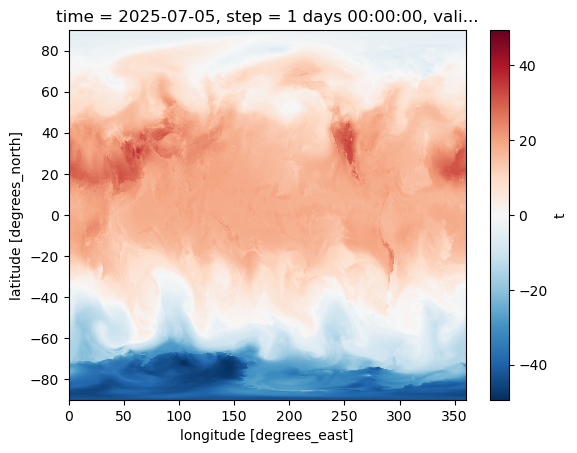

In [18]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="t",
    level_type="pl",
    level=850,
) - 273.15
field.plot()

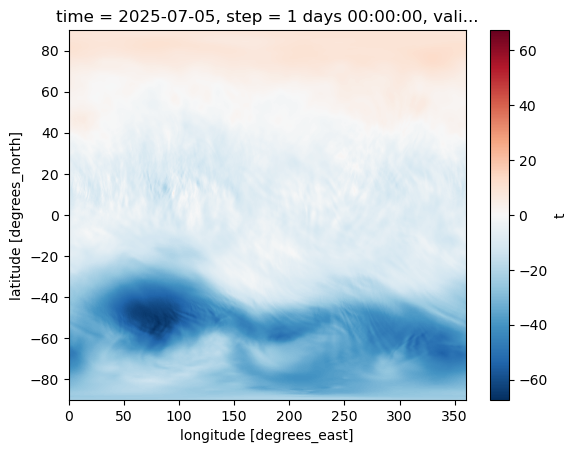

In [19]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="t",
    level_type="pl",
    level=1.5,
) - 273.15
field.plot()

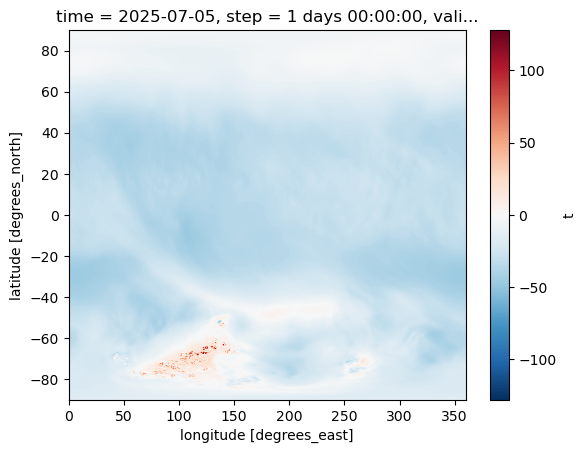

In [20]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="t",
    level_type="pl",
    level=0.5,
) - 273.15
field.plot()

### sfc

sfc 用于查询地面层要素场，仅支持 typeOfLevel="surface" 的要素场。

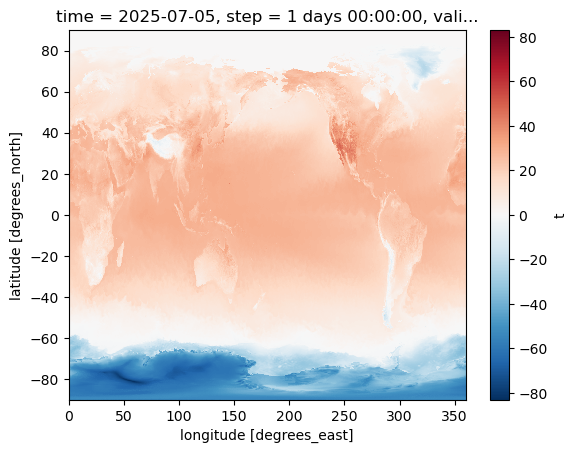

In [21]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="t",
    level_type="sfc",
) - 273.15
field.plot()

### ml

ml 用于检索模式面数据，正如之前提到的，模式面数据文件中只有一种层次类型，因此可以省略 level_type 参数。

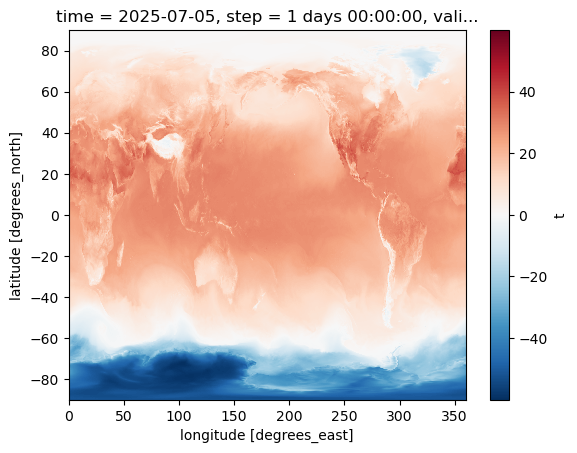

In [22]:
field = load_field_from_file(
    gfs_grib2_modelvar_file_path,
    parameter="t",
    level_type="ml",
    level=1,
) - 273.15
field.plot()

## 使用reki内置的层次

reki 内置两个层次值键值 `first_level` 和 `second_level`，可以用于定位有两个层次定义的要素场。

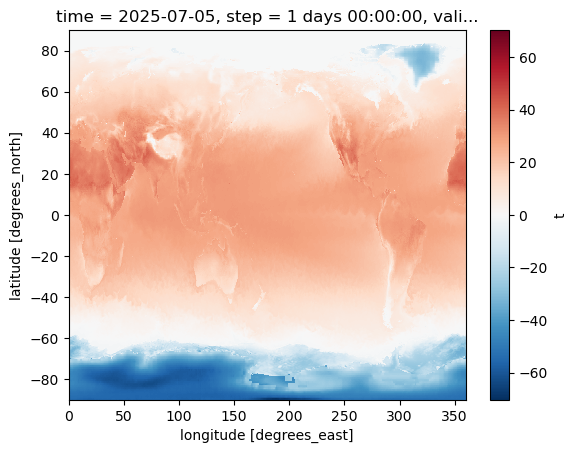

In [24]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="t",
    level_type="depthBelowLandLayer",
    level={
        "first_level": 0.1,
        "second_level": 0.4,
    },
) - 273.15
field.plot()